In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
!ls

drive  gdrive  sample_data


In [3]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.applications import VGG19, ResNet50, InceptionV3

sys.version

Using TensorFlow backend.


'3.6.9 (default, Apr 18 2020, 01:56:04) \n[GCC 8.4.0]'

In [0]:
base_path = 'gdrive/My Drive/Colab Notebooks/flowers/'

# daisy：菊花。 dandelion：蒲公英。 rose：玫瑰。 sunflower：向日葵。 tulip：郁金香。
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [0]:
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [6]:
print('length for each category:', [len(f) for f in fnames])

length for each category: [769, 1055, 784, 734, 984]


In [0]:
# train, test = train_test_split(fnames[0], train_size=0.8)
images = []
for names in fnames:
    one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_category_images)

In [8]:
print('number of images for each category:', [len(f) for f in images])

number of images for each category: [769, 1052, 784, 734, 984]


In [9]:

# In[]:
print('number of images for each category:', [len(f) for f in images])

# In[]: Calculate the minimal shape for all images
for i,imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d is the min shape for %s' % (np.min(widths), np.min(heights), categories[i]))


number of images for each category: [769, 1052, 784, 734, 984]
125,134 is the min shape for daisy
98,134 is the min shape for dandelion
80,150 is the min shape for rose
134,152 is the min shape for sunflower
134,134 is the min shape for tulip


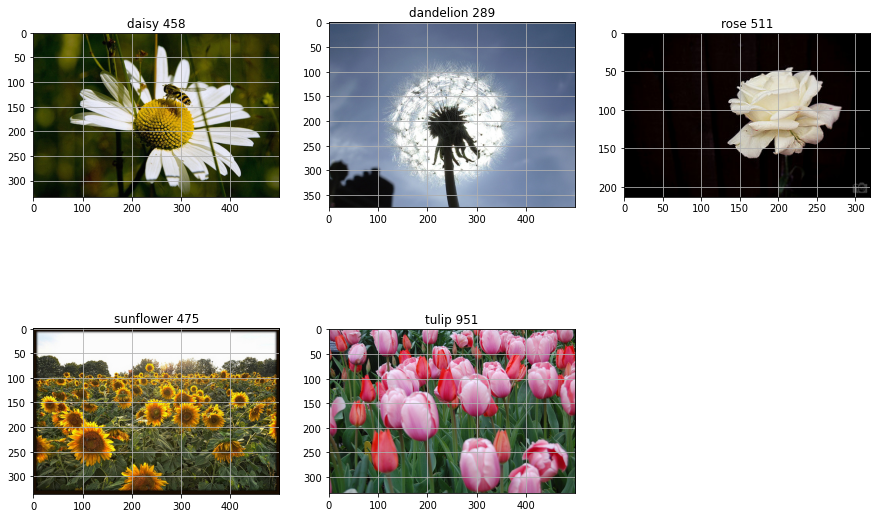

In [10]:

# In[]: Create a function to convert cv2 BGR format to RGB for showing
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)


# In[]: Show sample images for all flowers
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(2,3,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(cvtRGB(imgs[idx]))
    plt.grid('off')
    plt.title(categories[i]+' '+str(idx))
plt.show()
    


(333, 500, 3)
(224, 224, 3)


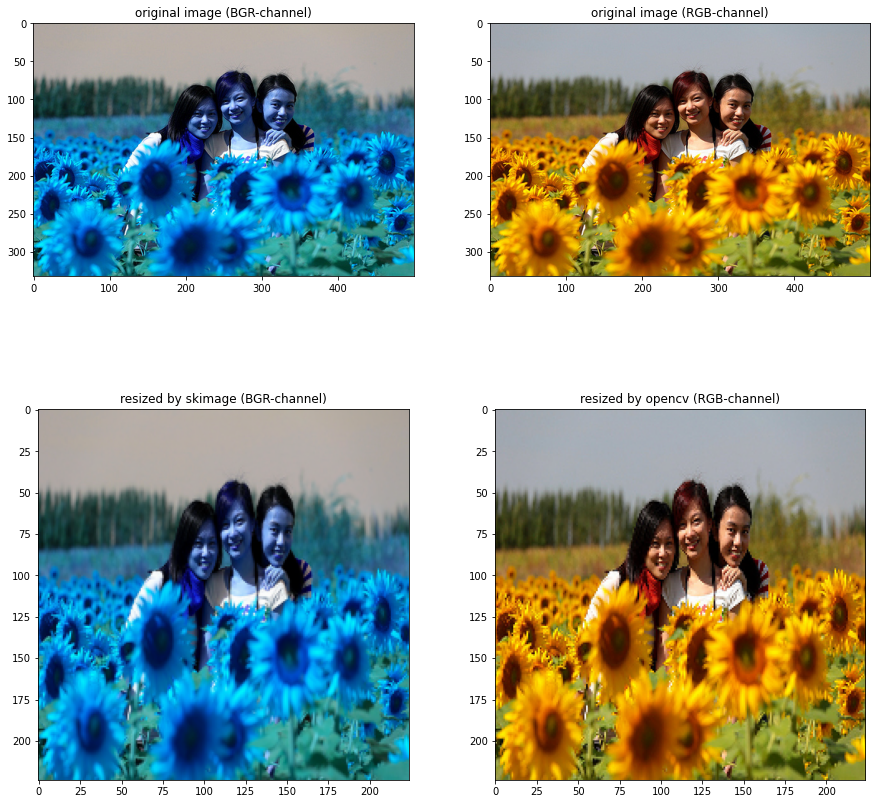

In [11]:

# In[]: Resize all the images to 256x256
img_width, img_height = 224, 224

img = images[3][659]
print(img.shape)
resized_img = resize(img, (img_width, img_height, 3))
resized_img2 = cv2.resize(img,(img_width, img_height), interpolation = cv2.INTER_CUBIC)
print(resized_img.shape)
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('original image (BGR-channel)')
plt.grid(False)
plt.imshow(img)
plt.subplot(2,2,2)
plt.title('original image (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(img))
plt.subplot(2,2,3)
plt.title('resized by skimage (BGR-channel)')
plt.grid(False)
plt.imshow((resized_img))
plt.subplot(2,2,4)
plt.title('resized by opencv (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(resized_img2))
plt.show()


In [0]:

# In[]:
# Apply resize to all images
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])
    

In [13]:


# In[]: Split dataset to 80% of training and 20% of validation
train_images = []
val_images = []
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.8, test_size=0.2)
    train_images.append(train)
    val_images.append(test)  
 
    
# In[]: Creat labels
len_train_images = [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images:', np.sum(len_train_images))
train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i
        
len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('sum of val_images:', np.sum(len_val_images))
val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i    
     
    

[615, 841, 627, 587, 787]
sum of train images: 3457
[154, 211, 157, 147, 197]
sum of val_images: 866


In [14]:
# In[]: Convert image data to numpy array
#Convert and pre-processing
#convert class labels to binary class labels

tmp_train_imgs = []
tmp_val_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
for imgs in val_images:
    tmp_val_imgs += imgs
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)    
    
# In[]:
print('Before converting')
print('train data:', train_images.shape)
print('train labels:', train_categories.shape)

train_data = train_images.astype('float32')
val_data = val_images.astype('float32')
train_labels = np_utils.to_categorical(train_categories, len(categories))
val_labels = np_utils.to_categorical(val_categories, len(categories))
print()
print('After converting')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)    
    

Before converting
train data: (3457, 224, 224, 3)
train labels: (3457,)

After converting
train data: (3457, 224, 224, 3)
train labels: (3457, 5)


In [15]:
# In[]: Shuffle the dataset (set a seed and randomize both the data and the labels)
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)    

# In[]:
train_data = train_data[:3400]
train_labels = train_labels[:3400]
val_data = val_data[:860]
val_labels = val_labels[:860]
print('shape of train data:', train_data.shape)
print('shape of train labels:', train_labels.shape)
print('shape of val data:', val_data.shape)
print('shape of val labels:', val_labels.shape)    
# In[]:
#WEIGHTS_PATH_NO_TOP = 'drive/My Drive/AI/My_Model/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
WEIGHTS_PATH_NO_TOP =  'weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'  


shape of train data: (3400, 224, 224, 3)
shape of train labels: (3400, 5)
shape of val data: (860, 224, 224, 3)
shape of val labels: (860, 5)


In [0]:

# In[]:
def create_model_from_ResNet50():

    """
     Use ResNet-50 (this model's code is from https://www.kaggle.com/cokastefan/keras-resnet-50)
    """
    model = Sequential()

    model.add(ResNet50(include_top=False, pooling='avg', weights="imagenet"))
    #model.add(Flatten())
    #model.add(BatchNormalization())
    #model.add(Dense(2048, activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dense(1024, activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dense(len(categories), activation='softmax'))

    model.layers[0].trainable = False
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return model


In [29]:

model_ResNet50 = create_model_from_ResNet50()
model_ResNet50.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
# In[]: Prepare input data
# Parameters
batch_size = 32
epochs1 = 50
epochs2 = 10
epochs3 = 30

# In[]: Create generator
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(
    train_data,
    train_labels,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    val_data,
    val_labels,
    batch_size=batch_size
)


In [31]:
# In[]:

start = time.time()

model_ResNet50_info = model_ResNet50.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs= 50, 
    validation_steps=len(val_data)/batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=val_generator, 
    verbose=2
)

end = time.time()
duration = end - start
print ('\n model_ResNet50 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs3) )
MODEL_FOLDER = 'gdrive/My Drive/Colab Notebooks/models/'
filepath = MODEL_FOLDER + "{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_digit4_acc', verbose=1, save_best_only=False, mode='max')

Epoch 1/50
 - 62s - loss: 0.7630 - acc: 0.7197 - val_loss: 1.9879 - val_acc: 0.1686
Epoch 2/50
 - 55s - loss: 0.4727 - acc: 0.8224 - val_loss: 2.4179 - val_acc: 0.1779
Epoch 3/50
 - 55s - loss: 0.4348 - acc: 0.8379 - val_loss: 2.0040 - val_acc: 0.1779
Epoch 4/50
 - 56s - loss: 0.3847 - acc: 0.8556 - val_loss: 2.4530 - val_acc: 0.1779
Epoch 5/50
 - 56s - loss: 0.3740 - acc: 0.8724 - val_loss: 2.5152 - val_acc: 0.1779
Epoch 6/50
 - 56s - loss: 0.3461 - acc: 0.8747 - val_loss: 2.4321 - val_acc: 0.1779
Epoch 7/50
 - 56s - loss: 0.3344 - acc: 0.8771 - val_loss: 2.6162 - val_acc: 0.1779
Epoch 8/50
 - 55s - loss: 0.3167 - acc: 0.8865 - val_loss: 2.6160 - val_acc: 0.1767
Epoch 9/50
 - 56s - loss: 0.2991 - acc: 0.8900 - val_loss: 2.5343 - val_acc: 0.1779
Epoch 10/50
 - 56s - loss: 0.3151 - acc: 0.8906 - val_loss: 2.6931 - val_acc: 0.1779
Epoch 11/50
 - 56s - loss: 0.3029 - acc: 0.8932 - val_loss: 2.4770 - val_acc: 0.1744
Epoch 12/50
 - 56s - loss: 0.2996 - acc: 0.8841 - val_loss: 2.3886 - val_a

KeyboardInterrupt: ignored